# (b) (1.5 point) Finding the most informative features for depression. 
Explore a filter feature selection method of your choice to identify the n features that are the most informative of depression on the training data. Report and discuss the 20 features that are most indicative of depression. Use the same machine learning algorithm as in question (a.i) to classify between depression and no depression based on n number of selected features, where n = 10, 20, 30, . . . , 50.
Plot the simple and balanced depression classification accuracy (for all participants, as well as female and male participants separately) and EO on the test set against the number n ofselected features. Please discuss the results.

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import sklearn
from sklearn import model_selection, preprocessing, metrics
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import SelectKBest
from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier


In [47]:
wd = '/kaggle/input/woz-speech/'
#Set training and test folder paths
training_path = wd+'features_train/features_train'
test_path = wd+'features_test/features_test'

#Load labels file
labels = pd.read_csv(wd+'labels.csv')

#Load feature description files, take out column 0 to use as header for training/test sets
features = pd.read_csv(wd+'feature_description.csv', encoding_errors='ignore', header=None, index_col=0)
features = features.index.tolist()
features

def load_data(folder_path):
    #Init empty dataframe
    res = pd.DataFrame()
    for file in os.listdir(folder_path):
        #for each speaker file
        if file.endswith('.csv'):
            #get participant id from filename, eg filename: 'spk_305.csv'
            participant = float(file.split('_')[1].split('.')[0])
            #find labels for the participant
            label = labels[labels['Participant_ID'] == participant]
            #load participant feature file
            file_path = os.path.join(folder_path, file)
            data_df = pd.read_csv(file_path, header=None, names=features)
            #Add labels and participant id columns
            data_df['participant'] = participant
            data_df['gender'] = label['Gender'].values[0]
            data_df['depression'] = label['Depression'].values[0]
            #combine everything to result
            res = pd.concat([res, data_df])
    return res

#Load training data
training_df = load_data(training_path)
test_df = load_data(test_path)

def preprocess_data(data):
    #drop missing va;ues since there is just 1 sample
    data_nona = data.dropna()
    #Normalization z-score
    scaler = StandardScaler()    
    # Store the columns to keep for later concatenation
    columns_to_keep = ['participant', 'gender', 'depression']
    # Extract the columns to be scaled and drop them from the original DataFrame
    temp = data_nona[columns_to_keep].copy()
    data_nona.drop(columns=columns_to_keep, axis=1, inplace=True)
    # Scale the remaining columns using StandardScaler and convert back to DataFrame
    scaled_data = pd.DataFrame(scaler.fit_transform(data_nona), columns=data_nona.columns)
    scaled_data.reset_index(drop=True, inplace=True)
    temp.reset_index(drop=True, inplace=True)
    # Concatenate the scaled data with the columns we kept earlier
    processed_data = pd.concat([scaled_data, temp], axis=1)
    return processed_data

# Calculates accuracy
# pass true and predicted labels
# return accuracy score
def calculate_total_accuracy(true_labels, predicted_labels):
    return accuracy_score(true_labels, predicted_labels)

# Calculates accuracy
# pass true and predicted labels
# return balanced accuracy score
def calculate_balanced_accuracy(true_labels, predicted_labels):
    #calculkate confusion matrix
    matrix = confusion_matrix(true_labels, predicted_labels)
    TP = matrix[1, 1]
    TN = matrix[0, 0]
    FP = matrix[0, 1]
    FN = matrix[1, 0]
    #For positive class, how many correct predictions
    accuracy_positive = TP/(TP+FN)
    #For negative class how many 
    accuracy_negative = TN/(TN+FP)
    return 0.5*(accuracy_positive + accuracy_negative)

#Calculates Equality of Opportunity
# pass true and predicted labels for male samples
# pass true and predicted labels for female samples
# return balanced accuracy score
def calculate_EO(true_labels_male, 
                 true_labels_female,
                 predicted_labels_male,
                predicted_labels_female):
    #Calculate True pistive rate for male gender with confusion matrix
    matrix_male = confusion_matrix(true_labels_male, predicted_labels_male)
    TP = matrix_male[1, 1]
    TN = matrix_male[0, 0]
    FN = matrix_male[1, 0]
    TPR_male = TP/(TP+FN)

    #Calculate True pistive rate for female gender with confusion matrix
    matrix_female = confusion_matrix(true_labels_female, predicted_labels_female)
    TP = matrix_female[1, 1]
    TN = matrix_female[0, 0]
    FN = matrix_female[1, 0]
    TPR_female = TP/(TP+FN)
    
    # Calculate EO
    return 1-abs(TPR_male-TPR_female) 

#Function to calculate majority votings
#Pass labels
#Returns mode or which label was predicted most
def majority_voting(df):
    counts = df.value_counts()
    return counts.idxmax()

#Function to calculate all metrics
#Pass true labels, predicted labels and a reference(test/val) dataframe
#referece dataframe should have all labels and features
#Returns a dictionary with all the metric calculated
def calculate_metrics(y_true, y_pred, test_data, EO=True):
    # Initialize metrics
    metrics = {}
    #---------------------------------------------------CALCULATING TOTAL METRICS
    #calculate total accuracy
    metrics["Total accuracy"] = calculate_total_accuracy(y_true, y_pred)
    #calculate total balanced accuracy
    metrics["Total Balanced accuracy"] = calculate_balanced_accuracy(y_true, y_pred)
    #calculate total EO
    if(EO):
        #find gender based indices for true labels from data
        male_indices = test_data[test_data['gender']==1].index
        female_indices = test_data[test_data['gender']==0].index
        #separate true labels based on indices
        male_true = y_true.loc[male_indices]
        female_true = y_true.loc[female_indices]
        #Find the corresponding indices for predicted labels from true_labels
        male_true_index_list = male_true.index.tolist()
        female_true_index_list = female_true.index.tolist()
        #Get separated predicted labels based on gender
        male_predicted = y_pred[[male_true_index_list.index(index) for index in male_true_index_list]]
        female_predicted = y_pred[[female_true_index_list.index(index) for index in female_true_index_list]]
        metrics["Total EO"] = calculate_EO(male_true, female_true, male_predicted, female_predicted)
    #-------------------------------------------------CALCULATING AGGREGATED METRICS FOR EACH PARTICIPANT
    predictions_df = pd.DataFrame({'participant': test_data['participant'], 'predicted_label': y_pred, 'true_label': y_true})
    aggregated_y_true = predictions_df.groupby('participant')['true_label'].agg(majority_voting)
    aggregated_y_pred = predictions_df.groupby('participant')['predicted_label'].agg(majority_voting)
    #Calculate aggregated accuracy score
    metrics["Aggregated accuracy score"] = calculate_total_accuracy(aggregated_y_true, aggregated_y_pred)
    #Calculate balanced aggregated accuracy
    metrics["Aggregated balanced accuracy score"] = calculate_balanced_accuracy(aggregated_y_true, aggregated_y_pred)
    if(EO):
        #Calculate aggregated EOs
        male_predictions_df = pd.DataFrame({'participant': test_data['participant'].loc[male_indices], 'predicted_label': y_pred, 'true_label': y_true})
        male_aggregated_y_true = male_predictions_df.groupby('participant')['true_label'].agg(majority_voting)
        male_aggregated_y_pred = male_predictions_df.groupby('participant')['predicted_label'].agg(majority_voting)
        female_predictions_df = pd.DataFrame({'participant': test_data['participant'].loc[female_indices], 'predicted_label': y_pred, 'true_label': y_true})
        female_aggregated_y_true = female_predictions_df.groupby('participant')['true_label'].agg(majority_voting)
        female_aggregated_y_pred = female_predictions_df.groupby('participant')['predicted_label'].agg(majority_voting)
        metrics["Aggregated EO score"] = calculate_EO(male_aggregated_y_true, female_aggregated_y_true, male_aggregated_y_pred, female_aggregated_y_pred)
    
    return metrics

In [17]:
training_data = preprocess_data(training_df)
X = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y = training_data['depression']

#Choosing the most infomative components for depression based on F value
best = SelectKBest(k=20).fit(X, y)
cols_idxs = best.get_support(indices=True)
print('Most predictive features:', list(X.columns[cols_idxs]))

Most predictive features: ['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'loudness_sma3_amean', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'mfcc3_sma3_amean', 'HNRdBACF_sma3nz_amean', 'F1frequency_sma3nz_amean', 'spectralFluxV_sma3nz_amean', 'spectralFluxV_sma3nz_stddevNorm', 'equivalentSoundLevel_dBp']


In [37]:
#------------------------------Trying different numbers of features-------------------------------------------------------

warnings.filterwarnings("ignore")
training_data = preprocess_data(training_df)
X = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y = training_data['depression']

# Define the depths to experiment with
num_features = range(10, 50, 10)
# Initialize metrics
metrics = {}

# Perform cross-validation for each tree depth
for n in num_features:
    #Find n best features for depression
    best = SelectKBest(k=n).fit(X, y)
    idxs = best.get_support(indices=True)
    X_new = X.iloc[:, idxs]
    # Initialize decision tree model
    tree = DecisionTreeClassifier(max_depth=70, criterion='entropy')
    # Cross validation k fold, 4:1::training:validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    #list to store metrics for each cross validation split
    fold_metrics = []

    # Perform cross-validation and collect metrics
    for train_index, val_index in kf.split(X):
        X_train, X_val = X_new.iloc[train_index], X_new.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        #Fit the training set
        tree.fit(X_train, y_train)
        #Predict validation set
        y_pred = tree.predict(X_val)
        #calculate metrics
        fold_metrics.append(calculate_metrics(y_val, y_pred, training_data.iloc[val_index]))

    #find avg metrics for each number of features
    metrics[n] = {}
    sums = {}
    for metric in fold_metrics:
        for key, value in metric.items():
            sums[key] = sums.get(key, 0) + value
    for key in sums:
        sums[key]/=len(fold_metrics)
    metrics[n] = sums

#Print metrics for all the hyperparameters (number of features)
for n in metrics:
    print(f"for {n} features: ")
    print(metrics[n]['Aggregated balanced accuracy score'])
    print()
    

for 10 features: 
0.7097222222222223

for 20 features: 
0.7273809523809524

for 30 features: 
0.8067460317460318

for 40 features: 
0.7936507936507937



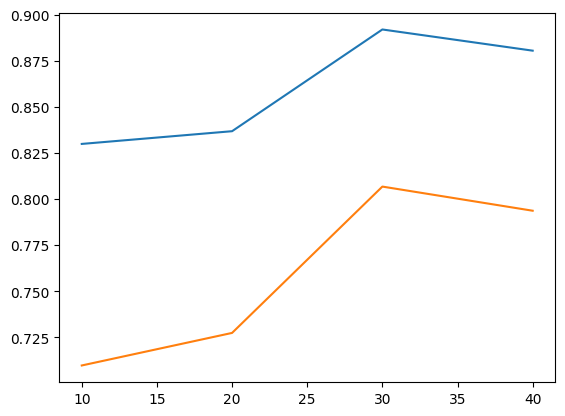

In [39]:
acc = []
bac = []
for n in metrics:
    acc.append(metrics[n]['Aggregated accuracy score'])
    bac.append(metrics[n]['Aggregated balanced accuracy score'])
plt.plot(metrics.keys(), acc)
plt.plot(metrics.keys(), bac)

30 features seems to be ideal. 

In [48]:
# ---------------------------------------------------------Testing for best depth----------------------------------------------------------------
test_data = preprocess_data(test_df)
training_data = preprocess_data(training_df)
X_train = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y_train = training_data['depression']
X_test = test_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y_test = test_data['depression']
num_features = 30

#Find n best features for depression
best = SelectKBest(k=num_features).fit(X_train, y_train)
idxs = best.get_support(indices=True)
X_new = X_train.iloc[:, idxs]
X_test_new = X_test.iloc[:, idxs]
# Initialize decision tree model
tree = DecisionTreeClassifier(max_depth=70, criterion='entropy')
# Cross validation k fold, 4:1::training:validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
#list to store metrics for each cross validation split
fold_metrics = []

# Perform cross-validation and collect metrics
for train_index, val_index in kf.split(X_train):
    X_train, X_val = X_new.iloc[train_index], X_new.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #Fit the training set
    tree.fit(X_train, y_train)
    #Predict validation set
    y_pred = tree.predict(X_val)
    #calculate metrics
    fold_metrics.append(calculate_metrics(y_val, y_pred, training_data.iloc[val_index]))

y_pred = tree.predict(X_test)
#get metrics
metrics = calculate_metrics(y_test, y_pred, test_data)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope
- F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope
- F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2
- F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope
- F0semitoneFrom27.5Hz_sma3nz_stddevNorm
- ...


In [27]:
class PCA_(decomposition.PCA):
    def __init__(self, x_train, x_test):
        super().__init__()
        self.x_train = x_train
        self.x_test = x_test
    
    def run_pca(self):
        #Find all PCs for the data
        self.fit(self.x_train)
        #Transform the data into the new feature space
        self.x_train = self.transform(self.x_train)
        self.x_test = self.transform(self.x_test)
    
    def best_PCs(self, Y, k):
        #Find the k best PCs for predicting a given outcome Y (based on F score)
        best = SelectKBest(k=k).fit(self.x_train, Y)
        return pd.DataFrame(best.transform(self.x_train)), pd.DataFrame(best.transform(self.x_test))
    


In [41]:
warnings.filterwarnings("ignore")
training_data = preprocess_data(training_df)
X = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
test_data = preprocess_data(test_df)
X_test = test_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y = training_data['depression']
pca = PCA_(X, X_test)
pca.run_pca()

# Define the depths to experiment with
num_features = range(10, 60, 10)
# Initialize metrics
metrics = {}

# Perform cross-validation for each tree depth
for n in num_features:
    #Find n best features for depression
    X, X_test = pca.best_PCs(y, n)
    # Initialize decision tree model
    tree = DecisionTreeClassifier(max_depth=70, criterion='entropy')
    # Cross validation k fold, 4:1::training:validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    #list to store metrics for each cross validation split
    fold_metrics = []

    # Perform cross-validation and collect metrics
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        #Fit the training set
        tree.fit(X_train, y_train)
        #Predict validation set
        y_pred = tree.predict(X_val)
        #calculate metrics
        fold_metrics.append(calculate_metrics(y_val, y_pred, training_data.iloc[val_index]))

    #find avg metrics for each number of features
    metrics[n] = {}
    sums = {}
    for metric in fold_metrics:
        for key, value in metric.items():
            sums[key] = sums.get(key, 0) + value
    for key in sums:
        sums[key]/=len(fold_metrics)
    metrics[n] = sums

#Print metrics for all the hyperparameters (number of features)
for n in metrics:
    print(f"for {n} features: ")
    print(metrics[n]['Aggregated balanced accuracy score'])
    print()

for 10 features: 
0.664484126984127

for 20 features: 
0.6843253968253968

for 30 features: 
0.6916666666666667

for 40 features: 
0.699404761904762

for 50 features: 
0.6843253968253968



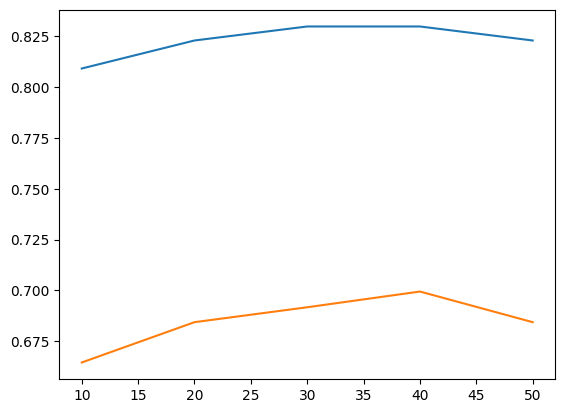

In [42]:
acc = []
bac = []
for n in metrics:
    acc.append(metrics[n]['Aggregated accuracy score'])
    bac.append(metrics[n]['Aggregated balanced accuracy score'])
plt.plot(metrics.keys(), acc)
plt.plot(metrics.keys(), bac)

PCA is not helpful in this application.